In [1]:
# IT24101672.ipynb - Online Dating Matches Prediction using Random Forest Regressor
# IT24101672 Arachchi.K.A.T
# Model: Random Forest Regressor (Full Pipeline with Evaluation & Visualization)

# INSTALL & IMPORT LIBRARIES8
!pip install numpy pandas matplotlib seaborn scikit-learn joblib -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
url ="https://raw.githubusercontent.com/kaveeshaadithya03/AIML/refs/heads/main/Online_Dating_Behavior_Dataset.csv"
data = pd.read_csv(url, encoding='latin-1')
df = pd.DataFrame(data)
data.head()

,Gender,PurchasedVIP,Income,Children,Age,Attractiveness,Matches
0,0,1,51777,3,47,5,70
1,1,0,36646,0,42,7,130
2,0,0,53801,1,25,5,0
3,0,0,56105,0,35,8,0
4,0,0,55597,1,36,6,0


[[ 7.88553059e+02 -6.18746377e+00]
 [-1.43424448e+04  5.44499304e+01]
 [ 2.81254988e+03 -7.60816918e+01]
 ...
 [-1.35944499e+03  4.38889403e+01]
 [-5.28244485e+03  6.42778263e+01]
 [-7.91344970e+03 -7.58497145e+01]]


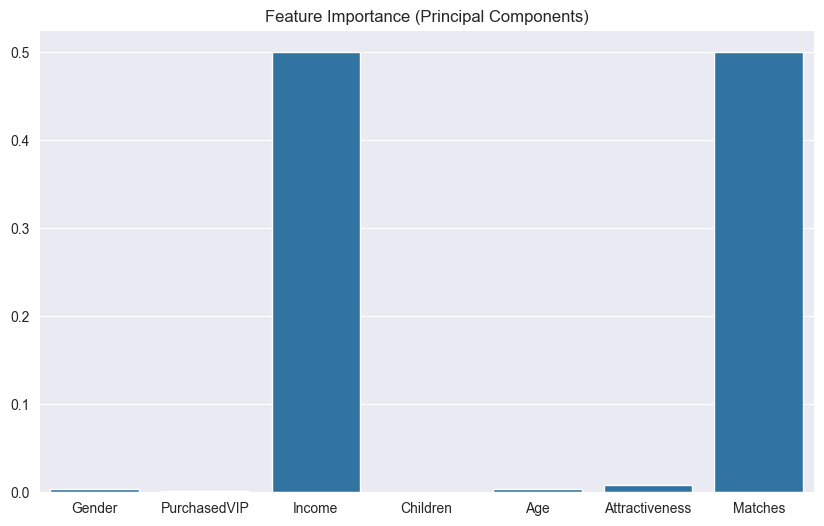

In [4]:
from sklearn.decomposition import PCA

#preprocessing part
# ensure all data is numeric for PCA
numeric_df = df.select_dtypes(include=[np.number])

pca = PCA(n_components=2)
df_pca = pca.fit_transform(numeric_df)

print(df_pca)
#visualization part
features =numeric_df.columns.tolist()
importances = np.abs(pca.components_).mean(axis=0)

plt.figure(figsize=(10,6))
sns.barplot(x=features, y=importances)
plt.title('Feature Importance (Principal Components)')
plt.show()

In [5]:
# STEP 1 CONTINUED: DATA PREPARATION
# Define features and target
X = df.drop('Matches', axis=1)  # All columns except 'Matches'
y = df['Matches']               # Target: Number of matches

# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# FIXED LINE BELOW
print(f"\nTraining Set: {X_train.shape} | Test Set: {X_test.shape}")

# Scale features (important for some models, optional for RF but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training Set: (800, 6) | Test Set: (200, 6)


In [6]:
# STEP 2: BASELINE RANDOM FOREST MODEL
print("STEP 2: TRAINING BASELINE RANDOM FOREST MODEL")

# Initialize and train baseline model
rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42)
rf_baseline.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_baseline = rf_baseline.predict(X_test_scaled)

# Evaluate baseline
mse = mean_squared_error(y_test, y_pred_baseline)
mae = mean_absolute_error(y_test, y_pred_baseline)
r2 = r2_score(y_test, y_pred_baseline)

print(f"Baseline Model Performance:")
print(f"  RMSE: {np.sqrt(mse):.2f}")
print(f"  MAE:  {mae:.2f}")
print(f"  R²:   {r2:.4f}")

# Cross-validation score
cv_scores = cross_val_score(rf_baseline, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"  5-Fold CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

STEP 2: TRAINING BASELINE RANDOM FOREST MODEL
Baseline Model Performance:
  RMSE: 0.00
  MAE:  0.00
  R²:   1.0000
  5-Fold CV R²: 1.0000 ± 0.0000


In [7]:
# STEP 3: HYPERPARAMETER TUNING WITH GRID SEARCH
print("STEP 3: HYPERPARAMETER TUNING USING GRIDSEARCHCV")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize GridSearch with cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

# Best model
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV R² Score: {grid_search.best_score_:.4f}")

STEP 3: HYPERPARAMETER TUNING USING GRIDSEARCHCV
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV R² Score: 0.9931


STEP 4: FINAL MODEL EVALUATION
Final Model Performance:
  RMSE: 4.36
  MAE:  3.22
  R²:   0.9930
  5-Fold CV R²: 0.9931 ± 0.0013


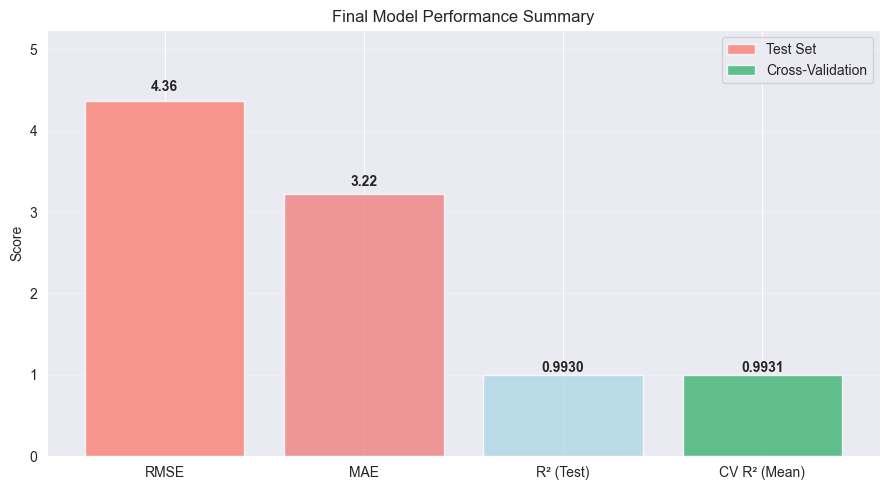

In [15]:
# STEP 4: EVALUATE FINAL MODEL
print("STEP 4: FINAL MODEL EVALUATION")

# Predict with best model
y_pred = best_rf.predict(X_test_scaled)

# Evaluate
mse_final = mean_squared_error(y_test, y_pred)
mae_final = mean_absolute_error(y_test, y_pred)
r2_final = r2_score(y_test, y_pred)

print(f"Final Model Performance:")
print(f"  RMSE: {np.sqrt(mse_final):.2f}")
print(f"  MAE:  {mae_final:.2f}")
print(f"  R²:   {r2_final:.4f}")

# Cross-validation on best model
cv_final = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"  5-Fold CV R²: {cv_final.mean():.4f} ± {cv_final.std():.4f}")

# --- VISUALIZATION 6: Performance Metrics Summary (Bar Chart) ---
metrics = ['RMSE', 'MAE', 'R² (Test)', 'CV R² (Mean)']
values = [np.sqrt(mse_final), mae_final, r2_final, cv_final.mean()]

plt.figure(figsize=(9, 5))
bars = plt.bar(metrics[:-1], values[:-1], color=['salmon', 'lightcoral', 'lightblue'], alpha=0.8, label='Test Set')
plt.bar(metrics[-1], values[-1], color='mediumseagreen', alpha=0.8, label='Cross-Validation')

for i, v in enumerate(values):
    if i < 2:
        plt.text(i, v + (v*0.02), f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
    else:
        plt.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Score')
plt.title('Final Model Performance Summary')
plt.ylim(0, max(values[:-1])*1.2)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE ANALYSIS
Top Features by Importance:


,Feature,Importance
0,Gender,0.650354
1,PurchasedVIP,0.163733
5,Attractiveness,0.120283
2,Income,0.032922
4,Age,0.023342
3,Children,0.009366


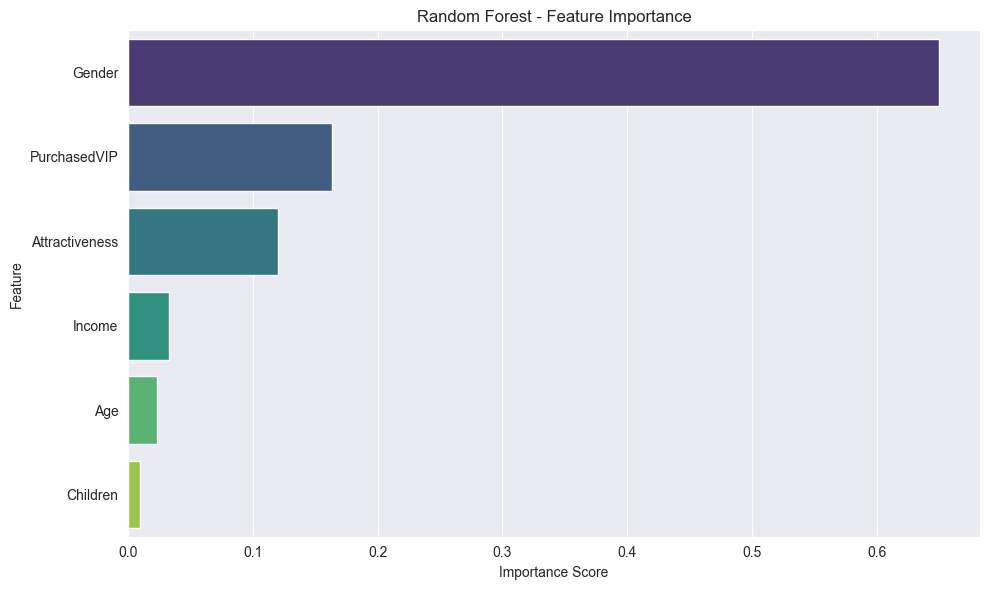

In [9]:
# FEATURE IMPORTANCE ANALYSIS
print("FEATURE IMPORTANCE ANALYSIS")

# Get feature names
feature_names = X.columns

# Get importance from best model
importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Top Features by Importance:")
display(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

PCA VISUALIZATION (2D REDUCTION)


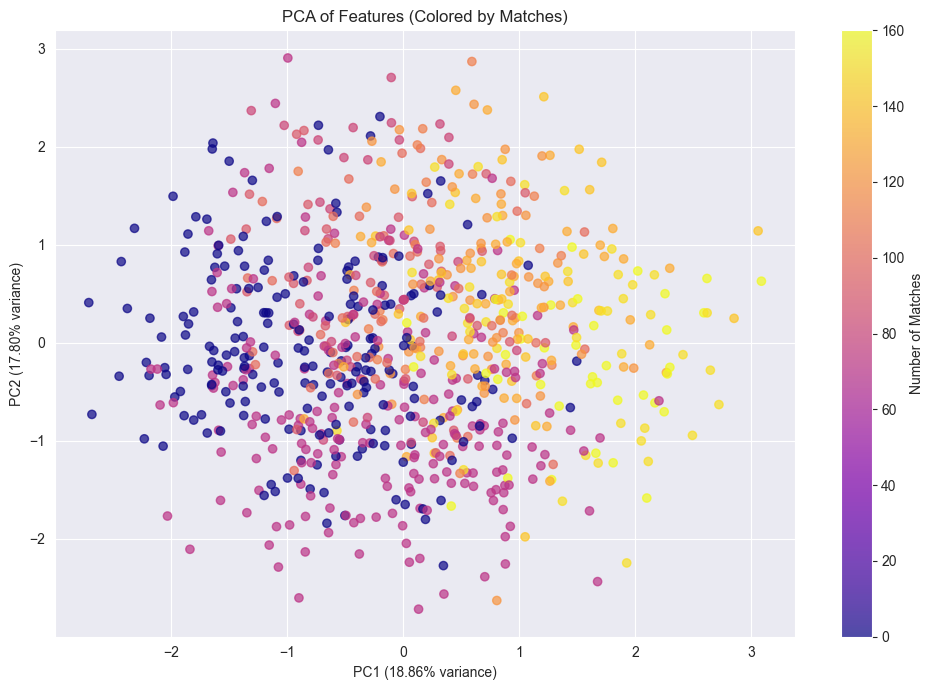

In [10]:
# PCA VISUALIZATION (2D)
print("PCA VISUALIZATION (2D REDUCTION)")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='plasma', alpha=0.7)
plt.colorbar(scatter, label='Number of Matches')
plt.title('PCA of Features (Colored by Matches)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.tight_layout()
plt.show()

STEP 5: PREDICTION VISUALIZATION


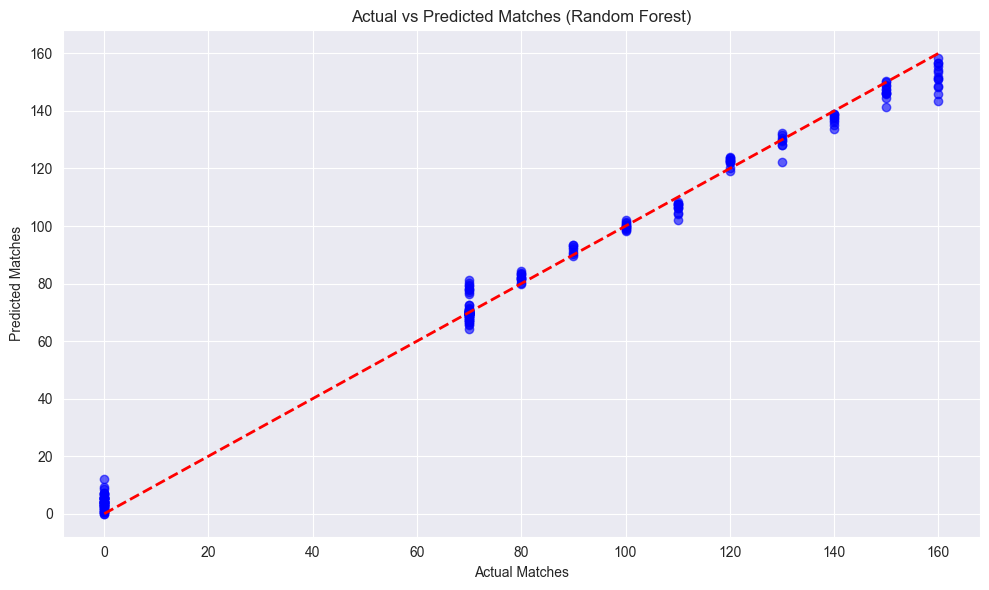

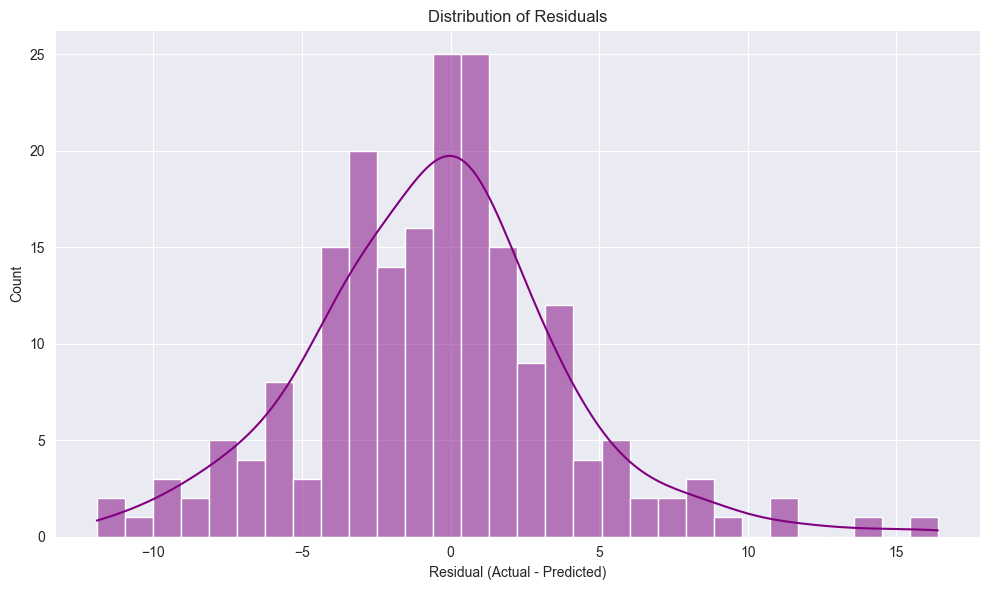

In [11]:
# STEP 5: VISUALIZATION - PREDICTIONS vs ACTUAL
print("STEP 5: PREDICTION VISUALIZATION")

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Matches')
plt.ylabel('Predicted Matches')
plt.title('Actual vs Predicted Matches (Random Forest)')
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.show()

In [12]:
# TEST PREDICTIONS ON SAMPLE DATA
print("SAMPLE PREDICTIONS ON TEST DATA")

# Show 10 sample predictions
sample = X_test.head(10).copy()
sample['Actual_Matches'] = y_test.head(10).values
sample['Predicted_Matches'] = y_pred[:10].round(1)

print("Sample Predictions:")
display(sample)

SAMPLE PREDICTIONS ON TEST DATA
Sample Predictions:


,Gender,PurchasedVIP,Income,Children,Age,Attractiveness,Actual_Matches,Predicted_Matches
521,0,0,59920,0,39,6,0,4.2
737,0,0,56308,0,47,6,0,7.2
740,0,1,62210,3,40,2,70,69.6
660,1,0,56628,1,34,4,100,99.8
411,1,1,36659,0,37,7,130,131.8
678,1,1,62897,2,39,1,70,79.4
626,0,0,35781,2,49,8,0,3.5
513,1,0,58384,0,35,4,100,99.2
859,0,0,39324,0,45,6,0,3.9
136,0,0,56078,2,32,8,0,5.6


In [13]:
# STEP 6: SAVE THE COMPLETE MODEL PACKAGE

# Create a dictionary to save everything
model_package = {
    'model': best_rf,
    'scaler': scaler,
    'features': list(X.columns),
    'performance': {
        'RMSE': np.sqrt(mse_final),
        'MAE': mae_final,
        'R2': r2_final
    },
    'best_params': grid_search.best_params_
}
# Save to file
joblib.dump(model_package, 'online_dating_rf_model_package.pkl')
print("Model package saved as 'online_dating_rf_model_package.pkl'")

Model package saved as 'online_dating_rf_model_package.pkl'


In [14]:
# LOAD AND REUSE MODEL
print("LOADING MODEL FOR FUTURE USE")
# Load the saved model
loaded = joblib.load('online_dating_rf_model_package.pkl')
loaded_model = loaded['model']
loaded_scaler = loaded['scaler']

# Make a new prediction
sample_input = X_test.iloc[0:1]  # Take one row
scaled_input = loaded_scaler.transform(sample_input)
prediction = loaded_model.predict(scaled_input)

print(f"Sample Input Features:\n{sample_input}")
print(f"\nPredicted Matches: {prediction[0]:.1f}")

LOADING MODEL FOR FUTURE USE
Sample Input Features:
     Gender  PurchasedVIP  Income  Children  Age  Attractiveness
521       0             0   59920         0   39               6

Predicted Matches: 4.2
